# Fruits Detection 

This notebook builds an end-to-end multi-class image detector using Mask-RCNN which is an algorithm for image detection with state of the art results in this subject.

Link for Mask R-CNN repository : https://github.com/matterport/Mask_RCNN

link for scientific paper on Mask R-CNN : https://arxiv.org/abs/1703.06870

## 1. Problem

Identifying a fruit in an image and drawing a bounding box on it

## 2. Data 

The data we're using is from Kaggle's Fruit Images for Object Detection competition 
https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection

## 3. Evaluation 

The evaluation metric we're going to use is the accuracy of the model in classifying the fruits and IOU for the box regressor in drawing boxes

## 4. Features

Some information about the data:
* We're dealing with images (unstructured data) so it's probably best we use deep learning/ transfer learning.
* There are 3 classes of fruits (Bananas , apples and oranges)
* There are 240 images in the training set 
* There are 60 images in the test set 

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN.git

In [ ]:
import os 
os.chdir('Mask_RCNN')
os.getcwd()

* access /content/Mask_RCNN/mrcnn/model.py and comment line 2199 
* write below it this line: self.keras_model.add_metric(loss, name)


In [ ]:
!sudo python setup.py install 

In [ ]:
%tensorflow_version 1.x
import keras
import  tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
import shutil
import pathlib 
import random as rand
import cv2
from google.colab import drive 
from xml.etree import ElementTree 
from mrcnn.utils import Dataset
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import download_trained_weights
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
print(tf.__version__)
print(keras.__version__)

In [ ]:
drive.mount('/content/drive')

### Prepare The Data

The Mask-RCNN requires that train, validation and test datasets be managed by a mrcnn.utils.Dataset object 

**Static Variables**

In [61]:
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Fruit Detection/Mask-RCNN Model")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
IMAGENET_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_imagenet.h5")
DEFAULT = "Coco"
CLASS_NAMES = ["orange","apple","banana"]

In [62]:
class FruitDataset (Dataset):
  def extract_boxes(self,filename):
    """
    extracts bounding boxes of objects present in image from an xml file
    args:
    * filename: str,path : filename of xml file to parse
    """
    #load and parse the file 
    tree = ElementTree.parse(filename)
    # get the root of the document
    root = tree.getroot()
    # extract each bounding box 
    boxes = list ()
    for box in root.findall(".//object"):
      xmin = int(box.find(".//bndbox/xmin").text)
      ymin = int(box.find(".//bndbox/ymin").text)
      xmax = int(box.find(".//bndbox/xmax").text)
      ymax = int(box.find(".//bndbox/ymax").text)
      class_name = box.find("./name").text
      boxes.append([xmin,ymin,xmax,ymax,class_name])
    # extract image dimensions 
    width = int(root.find(".//size/width").text)
    height = int(root.find(".//size/height").text)
    return boxes , width , height

  def load_dataset(self,dataset_dir,is_train=True):
    """
    loads the dataset given the dataset directory 
    args:
    * dataset_dir: str or path, directory path containing the dataset
    * is_train: boolean, specifying if the directory is of train or test data
    """
    # define classes
    self.add_class("dataset",1,"apple")
    self.add_class("dataset",2,"banana")
    self.add_class("dataset",3,"orange")
    # define data locations
    for i,filename in enumerate(os.listdir(dataset_dir)):
      s = filename.split(".")
      if s[-1]=="jpg":
        imagepath = os.path.join(dataset_dir,filename)
        annotpath = os.path.join(dataset_dir,s[0]+".xml")
        boxes ,w ,h = self.extract_boxes(annotpath)
        if w and h :
          self.add_image("dataset",image_id=i,path=imagepath,annotation=annotpath)

  def load_mask(self,image_id):
    """
    loads the masks and the class name for every object in every image
    args:
    * image_id: int, int corresponding to the unique id of an image in dataset
    """
    #get the details of the image 
    info = self.image_info[image_id]
    # define box file locatuon 
    path = info ["annotation"]
    # load XML 
    boxes , w ,h = self.extract_boxes(path)
    # create an array mask for the image
    masks = np.zeros([h,w,len(boxes)],dtype="uint8")
    class_ids = list ()
    for i in range(len(boxes)):
      box = boxes[i]
      row_s,row_e = box[1],box[3]
      col_s,col_e = box[0],box[2]
      masks[row_s:row_e,col_s:col_e,i]=1
      class_ids.append(self.class_names.index(box[4]))
    return masks , np.asarray(class_ids,dtype="int32")
 
  def image_reference(self , image_id):
    info = self.image_info[image_id]
    return info["path"]

In [11]:
train_set = FruitDataset()
train_set.load_dataset("/content/drive/My Drive/Fruit Detection/Data/train",is_train=True)
train_set.prepare()
print("Train: " ,len(train_set.image_ids))

test_set = FruitDataset()
test_set.load_dataset ("/content/drive/My Drive/Fruit Detection/Data/test",is_train=False)
test_set.prepare()
print("Test : " ,len (test_set.image_ids))


Train:  207
Test :  56


###Visualize the Data

In [ ]:
def data_information(data):
  """
  outputs first 100 image informations in the dataset
  args:
  * dataset : mrcnn.utils.Dataset instance 
  """
  for image_id in data.image_ids:
    info = data.image_info[image_id]
    print(info)
    if image_id > 100:
      break

In [ ]:
data_information(train_set)

In [ ]:
data_information(test_set)

In [ ]:
def visualize_images(data): 
  """
  Visualizes 9 images from the dataset for better understanding of the data
  args:
  * dataset : mrcnn.utils.Dataset instance 
  """
  plt.figure(figsize=(10,10))
  for i in range(9):
    r= rand.randint(0,len(data.image_ids))
    image = data.load_image(r)
    mask, class_ids = data.load_mask(r)
    plt.subplot(3,3,i+1)
    plt.imshow(image)
    for j in range(mask.shape[2]):
      plt.imshow(mask[:,:,j],cmap="gray",alpha=0.5)
  plt.tight_layout()
  plt.show()

In [ ]:
visualize_images(train_set)

### Build The Model 

In [ ]:
class FruitConfig(Config):
  NAME = "fruit_cfg"
  NUM_CLASSES = 3+1
  STEPS_PER_EPOCH = len(train_set.image_ids)

In [10]:
def train_model(train_set,test_set,epochs,fine_tuning=False):
  """
  Trains a model with pre-trained weights 
  args:
  * train_set: mrcnn.utils.Dataset instance 
  * test_set: mrcnn.utils.Dataset instance 
  * epochs: int, number of epochs 
  * fine_tuning: boolean, whether to fine tune the model or not 
  """
  config = FruitConfig()
  model = MaskRCNN(mode="training",model_dir='/content/drive/My Drive/Fruit Detection/Mask-RCNN Model',config=config)
  
  if DEFAULT == "Coco":
    if not os.path.exists(COCO_MODEL_PATH):
      download_trained_weights(COCO_MODEL_PATH)
    weights_dir = COCO_MODEL_PATH
    print("Loading weights ",weights_dir)
    model.load_weights(weights_dir, by_name=True,exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
  
  else :
    weights_dir=model.get_imagenet_weights()
    os.rename(weights_dir,IMAGENET_MODEL_PATH)
    weights_dir = IMAGENET_MODEL_DIR
    print("Loading weights ",weights_dir)
    model.load_weights(weights_dir, by_name=True,exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

  model.train(train_set,test_set,learning_rate=config.LEARNING_RATE,epochs=epochs,layers="heads")

In [ ]:
train_model(train_set,test_set,epochs=10,fine_tuning=True)

Great We obtained 0.4 Loss from training for just 8 epochs. 
We can do better now with the trained model by fine tuning it.
I'm going to stop this project here but if you want you can finetune this model and experiment with different configurations you can make. 

In order to finetune the model load the trained model in this location /content/drive/My Drive/Fruit-Detection/Mask-RCNN-Model and train it again but change the layers argument to :
* ``3+``: Train Resnet stage 3 and up
* ``4+``: Train Resnet stage 4 and up
* ``5+``: Train Resnet stage 5 and up
* ``all``: train all the model

### Evaluate The Model

In [45]:
class PredictionConfig(Config):
  NAME = "fruit_cfg"
  NUM_CLASSES = 4
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

In [46]:
def evaluation_model():
  """
  creates an inference model for evaluation 
  args :
  * model: mrcnn.model.MaskRCNN instance 
  * weights_dir: str or path,path to the .h5 file of the weights
  """
  model = MaskRCNN(mode = 'inference',model_dir='./',config=cfg)
  model.load_weights("/content/drive/My Drive/Fruit Detection/Mask-RCNN Model/fruit_cfg20201013T0707/mask_rcnn_fruit_cfg_0008.h5",by_name=True)
  return model 

In [49]:
def evaluate_model (dataset,model,cfg):
  """
  evaluates the model with mAP metrics 
  args:
  * dataset: mrcnn.utils.Dataset instance
  * model: mrcnn.model.MaskRCNN instance
  * cfg: mrcnn.utils.Config instance
  """
  APS = list ()
  for image_id in dataset.image_ids :
    image, image_meta,gt_class_id,gt_bbox,gt_mask = load_image_gt(dataset,cfg,image_id,use_mini_mask=False)
    scaled_image = mold_image (image,cfg)
    sample = np.expand_dims(scaled_image,0)
    yhat = model.detect(sample,verbose=0)
    r = yhat [0]
    AP ,_,_,_= compute_ap(gt_bbox,gt_class_id,gt_mask,r["rois"],r["class_ids"],r["scores"],r["masks"])
    APS.append(AP)
  mAP=sum(APS)/len(APS)
  return mAP


In [50]:
cfg = PredictionConfig()
model = evaluation_model()
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Re-starting from epoch 8
Train mAP: 0.882
Test mAP: 0.725


In [71]:
def plot_predictions (dataset,model,class_names,cfg,n_images=5):
  """
  plots actual images from the dataset versus their predictions from the model 
  * dataset: mrcnn.utils.Dataset instance 
  * model: mrcnn.model.MaskRCNN instance
  * cfg: mrcnn.utils.Config instance
  * n_images: int, number of images to plot 
  """
  plt.figure(figsize=(15,15))
  for i in range(n_images):
    image = dataset.load_image(i)
    mask,_ = dataset.load_mask(i)
    scaled_image = mold_image(image,cfg)
    sample = np.expand_dims(scaled_image,0)
    yhat = model.detect(sample,verbose=0)[0]
    plt.subplot(n_images,2,2*i+1)
    plt.imshow(image)
    plt.title("actual")
    plt.axis(False)
    plt.grid(False)
  
    for j in range(mask.shape[2]):
      plt.imshow(mask[:,:,j],cmap="gray",alpha=0.3)
    plt.subplot(n_images,2,2*i+2)
    plt.title("prediction")
    plt.axis(False)
    plt.grid(False)
  
    for box,class_id in zip(yhat["rois"],yhat["class_ids"]):
      ymin,xmin,ymax,xmax = box
      width , height = xmax - xmin , ymax - ymin
      image = cv2.rectangle(image,(xmin,ymax),(xmax,ymin),(255,12,100),4)
      plt.text(xmin,ymax,class_names[class_id])
    plt.imshow(image)
    plt.grid(False)
  plt.tight_layout()
  plt.show()

In [ ]:
plot_predictions(train_set,model,cfg,n_images=5)

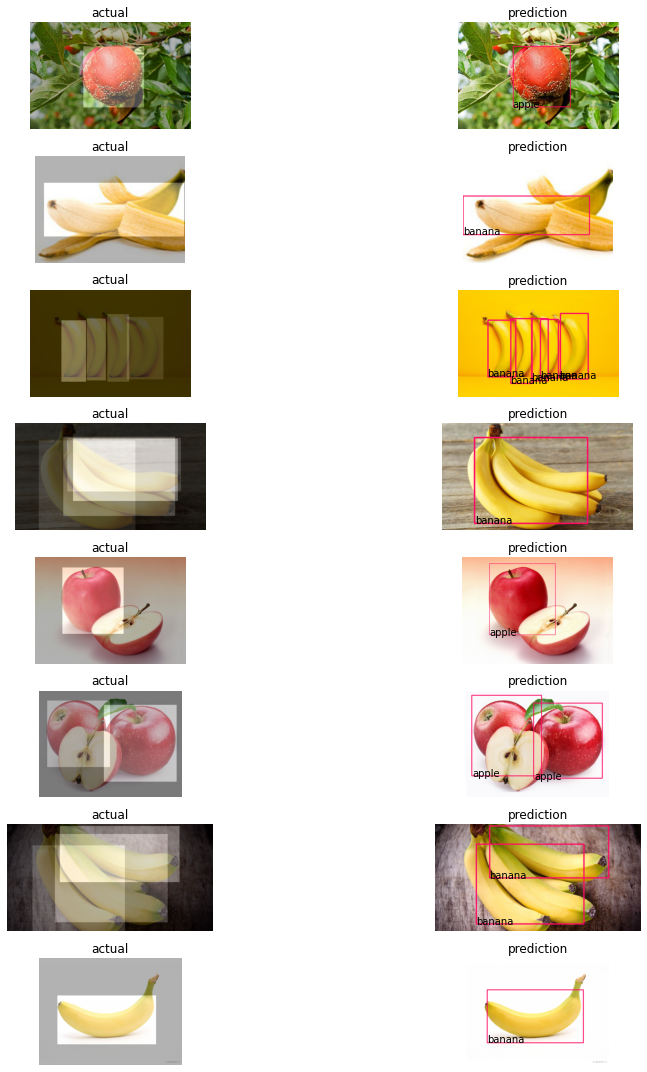

In [72]:
plot_predictions(train_set,model,CLASS_NAMES,cfg,n_images=8)